<a href="https://colab.research.google.com/github/camlab-bioml/2021_IMC_Jett/blob/main/non_function_version_gmm_em_expressions_cell_sizes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.optim as optim
import torch.distributions as D

import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets as datasets

In [2]:
## create data

n_clusters = 3
n_features = 2

## ground true expressions ##
true_expression_means = torch.tensor([
    [1, 2],
    [4, 3],
    [7, 9]
])

true_expression_covs = torch.tensor([
    [[.1, 0], [0, .1]],
    [[.1, 0], [0, .1]],
    [[.1, 0], [0, .1]]
])

true_size_means = torch.tensor([.4, .5, .6])

print(true_size_means)

true_size_stds = torch.tensor([.1, .05, .01])
true_size_stds

## other ground true for generating data ##
d_ws = torch.tensor([.95, .05])
z_ws = torch.tensor([1 / 4, 1 / 2, 1 / 4])
g_ws = torch.tensor([0.0667, 0.1333, 0.2000, 0.1000, 0.2667, 0.2333])

N = 10000
gs = np.sum(np.random.choice(len(d_ws), size = N, p = d_ws))
zs = N - gs

## simulate data
x = np.zeros((zs, n_features+4))
for i in range(zs):
  z = np.random.choice(n_clusters, size = 1, p = z_ws)[0]
  x[i] = np.append(np.random.multivariate_normal(true_expression_means[z], true_expression_covs[z]), [np.random.normal(true_size_means[z], true_size_stds[z]), 0, z, z+6])
  
xxx = np.zeros((gs, n_features+4))
for i in range(gs):

  g = np.random.choice(6, size = 1, p = g_ws)[0]
    
  if g == 0:
    idx = [0,0]
  elif g == 1:
    idx = [0,1]
  elif g == 2:
    idx = [0,2]
  elif g == 3:
    idx = [1,1]
  elif g == 4:
    idx = [1,2]
  else:
    idx = [2,2]
  
  xxx[i] = np.append(np.random.multivariate_normal( (true_expression_means[idx[0]] + true_expression_means[idx[1]]), (true_expression_covs[idx[0]] + true_expression_covs[idx[1]]) ),
                     [np.random.normal( (true_size_means[idx[0]] + true_size_means[idx[1]]), (true_size_stds[idx[0]] + true_size_stds[idx[1]]) ), 1, g, g])
  
xx = np.append(x, xxx).reshape(N,6)

tensor([0.4000, 0.5000, 0.6000])


In [3]:
## initialization

n_obs = N
n_features = 2
n_clusters = 3

#torch.manual_seed(42)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

emu_c = torch.tensor([
    [3, 1], # 1 2
    [5, 4], # 4 3
    [8, 7]
]) #, requires_grad=True, dtype=torch.float, device=device)

smu_c = torch.tensor([.45, .55, .65]) #, requires_grad=True, dtype=torch.float, device=device)

eco_c = 0.1 * torch.eye(n_features).tile(n_clusters, 1, 1)
sco_c = 0.1 * torch.ones(n_clusters, dtype=torch.float)

smu_cc = torch.zeros(n_clusters, n_clusters)
sco_cc = torch.zeros(n_clusters, n_clusters)

emu_cc = torch.zeros(n_clusters, n_clusters, n_features)
eco_cc = torch.zeros(n_clusters, n_clusters, n_features, n_features)

for j in range(n_clusters):
  for k in range(n_clusters):
    smu_cc[j,k] = smu_c[j] + smu_c[k]
    sco_cc[j,k] = sco_c[j] + sco_c[k]

    emu_cc[j,k] = (emu_c[j] + emu_c[k])
    eco_cc[j,k] = (eco_c[j] + eco_c[k])

#smu_c = torch.tensor(smu_c, requires_grad=True, dtype=torch.float, device=device)
#sco_c = torch.tensor(sco_c, requires_grad=True, dtype=torch.float, device=device)

#emu_c = torch.tensor(emu_c, requires_grad=True, dtype=torch.float, device=device)
#eco_c = torch.tensor(eco_c, requires_grad=True, dtype=torch.float, device=device)

#smu_cc = torch.tensor(smu_cc, requires_grad=True, dtype=torch.float, device=device)
#sco_cc = torch.tensor(sco_cc, requires_grad=True, dtype=torch.float, device=device)

#emu_cc = torch.tensor(emu_cc, requires_grad=True, dtype=torch.float, device=device)
#eco_cc = torch.tensor(eco_cc, requires_grad=True, dtype=torch.float, device=device)

####

pi_d0 = torch.tensor(0.9)

pi_c = torch.empty(n_clusters).fill_(1. / (n_clusters))

pi_cc = torch.triu(torch.ones(n_clusters, n_clusters))
pi_cc = pi_cc / torch.sum(pi_cc)
pi_cc[pi_cc == 0] = float('NaN')

In [4]:
## helper function
def _estimate_mean_cov_t1v2(X, S, r_ij, reg=1e-6):

  #n, p = X.shape
  #n, c = r_ij.shape

  smut = torch.zeros(n_clusters)
  scot = torch.zeros(n_clusters)

  emut = torch.zeros(n_clusters, n_features)
  ecot = torch.zeros(n_clusters, n_features, n_features)

  n_c = torch.sum(r_ij, dim=0) + reg # (c)

  for j in range(n_clusters):
    e_n = torch.round(n_c[j])
    idx = r_ij[:,j].argsort()[-e_n.int():]
    smut[j] = torch.mean(S[idx], 0)
    emut[j] = torch.mean(X[idx], 0)
    if e_n > 1:
      ecot[j] = torch.tensor(np.cov(X[idx].T, ddof=0)) + reg * torch.eye(n_features)
      scot[j] = torch.std(S[idx]) + reg
    else:
      ecot[j] = reg * torch.eye(n_features)
      scot[j] = reg
  return n_c, smut, scot, emut, ecot


def _estimate_mean_cov_t2v2(X, S, r_ijk, reg=1e-6):

  #n, p = X.shape
  #n, c, c = r_ijk.shape

  smut = torch.zeros(n_clusters, n_clusters)
  scot = torch.zeros(n_clusters, n_clusters)

  emut = torch.zeros(n_clusters, n_clusters, n_features)
  ecot = torch.zeros(n_clusters, n_clusters, n_features, n_features)

  n_cc = torch.sum(r_ijk, dim=0) + reg # (cxc)

  for j in range(n_clusters):
    for k in range(n_clusters):
      if not torch.isnan(n_cc[j,k]):
        e_n = torch.round(n_cc[j,k])
        idx = r_ijk[:,j,k].argsort()[-e_n.int():]
        smut[j,k] = torch.mean(S[idx], 0)
        emut[j,k] = torch.mean(X[idx], 0)
        if e_n > 1:
          scot[j,k] = torch.std(S[idx]) + reg
          ecot[j,k] = torch.tensor(np.cov(X[idx].T, ddof=0)) + reg * torch.eye(n_features)
        else:
          scot[j,k] = reg
          ecot[j,k] = reg * torch.eye(n_features)
  return n_cc, smut, scot, emut, ecot

def _ics(logL, n_obs, n_features, n_clusters): #, n, p, c
  params = ( (((n_features * n_features) - n_features)/2 + 2 * n_features + 3) * (((n_clusters * n_clusters) - n_clusters)/2 + 2 * n_clusters) ) - 1
  return 2 * (params - logL), -2 * logL + params * np.log(n_obs)

In [6]:
X = torch.tensor(xx[:,:2])
S = torch.tensor(xx[:,2])

## analytical version
n_epochs = 1000
tot = 1e-4
iter = 0
llv = [0.0]

log_pi_d0 = torch.log(pi_d0)
log_pi_d1 = torch.log(1 - pi_d0)

log_pi_c = torch.log(pi_c)
log_pi_cc = torch.log(pi_cc)

while iter < n_epochs:

  ### E-step:
  log_post_top0 = torch.zeros(n_clusters, n_obs)
  log_post_top1 = torch.zeros(n_clusters, n_clusters, n_obs)

  for j in range(n_clusters):
  
    el0 = D.MultivariateNormal(emu_c[j], eco_c[j]).log_prob(X.float())
    sl0 = D.Normal(smu_c[j], sco_c[j]).log_prob(S.float())
    log_post_top0[j] = log_pi_d0 + log_pi_c[j] + el0 + sl0
    
    for k in range(n_clusters):
      el1 = D.MultivariateNormal((emu_c[j] + emu_c[k])/2, (eco_c[j] + eco_c[k])/2).log_prob(X.float())
      #https://stats.stackexchange.com/questions/99363/mean-of-covariance-matrices
      #https://stats.stackexchange.com/questions/214174/calculating-the-covariance-matrix-for-the-mean-of-variables
      sl1 = D.Normal(smu_c[j] + smu_c[k], sco_c[j] + sco_c[k]).log_prob(S.float())
      
      if torch.isnan(pi_cc[j,k]): #lower triangular nan
        log_post_top1[j,k] = float("-Inf")
      else:
        log_post_top1[j,k] = log_pi_d1 + log_pi_cc[j,k] + el1 + sl1

  log_post_bot0 = torch.logsumexp(log_post_top0, 0) #n
  log_post_z = (log_post_top0 - log_post_bot0).T #nxc (rjk)

  log_post_top1 = log_post_top1.reshape(n_clusters * n_clusters, n_obs) #reshape
  log_post_bot1 = torch.logsumexp(log_post_top1, 0) #n
  log_post_g = (log_post_top1 - log_post_bot1).T #nxc (rijk)

  log_post_tot = torch.logsumexp(torch.vstack((log_post_top0, log_post_top1)),0)
  loss = -torch.mean(log_post_tot)

  log_post_d0 = log_post_bot0 - log_post_tot
  log_post_d1 = log_post_bot1 - log_post_tot

  log_post_dz = log_post_d0[:,None] + log_post_z
  log_post_dg = log_post_d1[:,None] + log_post_g

  ### M-step:

  log_pi_d0 = torch.logsumexp(log_post_d0, 0) - torch.log(torch.tensor(n_obs))

  r_ij = torch.exp(log_post_dz)
  n_c, smu_c, sco_c, emu_c, eco_c = _estimate_mean_cov_t1v2(X, S, r_ij)
  log_pi_c = torch.log(n_c) - torch.log(torch.tensor(n_obs))

  indx = []
  for j in range(log_post_dg.shape[1]):
    if torch.sum(torch.isinf(log_post_dg[:,j])) == log_post_dg.shape[0]:
      indx.append(j)
  log_post_dg[:,indx] = float('NaN')

  r_ijk = torch.exp(log_post_dg).reshape(n_obs, n_clusters, n_clusters)
  n_cc, smu_cc, sco_cc, emu_cc, eco_cc = _estimate_mean_cov_t2v2(X, S, r_ijk)
  log_pi_cc = torch.log(n_cc) - torch.log(torch.tensor(n_obs))
      
  print('Iteration', iter + 1, 'Likelihood: ', -loss, torch.exp(log_pi_d0))

  if abs(llv[-1] + loss) < tot:
    break
      
  llv.append(-loss)
  iter += 1
  
aic, bic = _ics(-loss, n_obs, n_features, n_clusters)
#return llv[1:], aic, bic

Iteration 1 Likelihood:  tensor(-27.5427) tensor(0.6436)
Iteration 2 Likelihood:  tensor(-6.5293) tensor(0.9461)
Iteration 3 Likelihood:  tensor(-8.8737) tensor(0.9517)
Iteration 4 Likelihood:  tensor(-10.2177) tensor(0.9517)
Iteration 5 Likelihood:  tensor(-10.4964) tensor(0.9517)
Iteration 6 Likelihood:  tensor(-10.4964) tensor(0.9517)


In [8]:
torch.exp(log_pi_d0)

tensor(0.9517)

In [9]:
torch.exp(log_pi_c)

tensor([0.2290, 0.4848, 0.2380])

In [10]:
torch.exp(log_pi_cc)

tensor([[1.5287e-06, 2.8217e-03, 4.9191e-03],
        [       nan, 1.4747e-04, 5.7032e-03],
        [       nan,        nan, 3.4661e-02]])

In [11]:
emu_c

tensor([[0.9948, 2.0004],
        [4.0021, 2.9967],
        [7.0200, 9.0043]])

In [12]:
smu_c

tensor([0.3986, 0.5006, 0.5999])

In [13]:
bic

tensor(674.9269)

In [50]:
## analytical versio (no loop)

log_pi_d0 = torch.log(pi_d0)
log_pi_d1 = torch.log(1 - pi_d0)

log_pi_c = torch.log(pi_c)
log_pi_cc = torch.log(pi_cc)

### E-step:
log_post_top0 = torch.zeros(n_clusters, n_obs)
log_post_top1 = torch.zeros(n_clusters, n_clusters, n_obs)

for j in range(n_clusters):
  
  el0 = D.MultivariateNormal(emu_c[j], eco_c[j]).log_prob(X.float())
  sl0 = D.Normal(smu_c[j], sco_c[j]).log_prob(S.float())
  log_post_top0[j] = log_pi_d0 + log_pi_c[j] + el0 + sl0
    
  for k in range(n_clusters):
    el1 = D.MultivariateNormal((emu_c[j] + emu_c[k])/2, (eco_c[j] + eco_c[k])/2).log_prob(X.float())
    #https://stats.stackexchange.com/questions/99363/mean-of-covariance-matrices
    #https://stats.stackexchange.com/questions/214174/calculating-the-covariance-matrix-for-the-mean-of-variables
    sl1 = D.Normal(smu_c[j] + smu_c[k], sco_c[j] + sco_c[k]).log_prob(S.float())
      
    #el1 = D.MultivariateNormal(emu_cc[j,k]/2, eco_cc[j,k]/2).log_prob(X.float())
    #sl1 = D.Normal(smu_cc[j,k], sco_cc[j,k]).log_prob(S.float())

    if torch.isnan(pi_cc[j,k]): #lower triangular nan
      log_post_top1[j,k] = float("-Inf")
    else:
      log_post_top1[j,k] = log_pi_d1 + log_pi_cc[j,k] + el1 + sl1

log_post_bot0 = torch.logsumexp(log_post_top0, 0) #n
log_post_z = (log_post_top0 - log_post_bot0).T #nxc (rjk)

log_post_top1 = log_post_top1.reshape(n_clusters * n_clusters, n_obs) #reshape
log_post_bot1 = torch.logsumexp(log_post_top1, 0) #n
log_post_g = (log_post_top1 - log_post_bot1).T #nxc (rijk)

'''
bot = torch.log(torch.exp(log_post_bot0) + torch.exp(log_post_bot1))
indices = bot == float("-inf")
if torch.sum(indices) > 0:
  ## look at which log prob is smaller
  ind = log_post_bot0[indices] < log_post_bot1[indices]  
  log_post_bot1[indices][ind] = 0
  log_post_bot0[indices][~ind] = 0
  bot[indices] = 0
loss = -torch.mean(bot)
  
log_post_d0 = log_post_bot0 - bot
log_post_d1 = log_post_bot1 - bot
'''

log_post_tot = torch.logsumexp(torch.vstack((log_post_top0, log_post_top1)),0)
loss = -torch.mean(log_post_tot)

log_post_d0 = log_post_bot0 - log_post_tot
log_post_d1 = log_post_bot1 - log_post_tot

log_post_dz = log_post_d0[:,None] + log_post_z
log_post_dg = log_post_d1[:,None] + log_post_g

### M-step:

#pi_d0 = torch.sum(torch.exp(log_post_d0)) / n_obs # one value
log_pi_d0 = torch.logsumexp(log_post_d0, 0) - torch.log(torch.tensor(n_obs))

r_ij = torch.exp(log_post_dz)
n_c, smu_c, sco_c, emu_c, eco_c = _estimate_mean_cov_t1v2(X, S, r_ij)
#pi_c = n_c / n_obs # c values
log_pi_c = torch.log(n_c) - torch.log(torch.tensor(n_obs))

indx = []
for j in range(log_post_dg.shape[1]):
  if torch.sum(torch.isinf(log_post_dg[:,j])) == log_post_dg.shape[0]:
    indx.append(j)
log_post_dg[:,indx] = float('NaN')

r_ijk = torch.exp(log_post_dg).reshape(n_obs, n_clusters, n_clusters)
n_cc, smu_cc, sco_cc, emu_cc, eco_cc = _estimate_mean_cov_t2v2(X, S, r_ijk)
#pi_cc = n_cc / n_obs  # cxc matrix  
log_pi_cc = torch.log(n_cc) - torch.log(torch.tensor(n_obs))
      
print('Iteration', iter + 1, 'Likelihood: ', -loss, torch.exp(log_pi_d0))

#if abs(llv[-1] + loss) < tot:
#  break
      
llv.append(-loss)
iter += 1

aic, bic = _ics(-loss, n_obs, n_features, n_clusters)

In [37]:
## initialization

n_obs = N
n_features = 2
n_clusters = 3

#torch.manual_seed(42)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

emu_c = torch.tensor([
    [2, 3], # 1 2
    [3, 5], # 4 3
    [7, 8]
], dtype=torch.float) #, requires_grad=True, , device=device)

smu_c = torch.tensor([.45, .55, .65], dtype=torch.float) #, requires_grad=True,  device=device)

eco_c = 0.1 * torch.eye(n_features).tile(n_clusters, 1, 1)
sco_c = 0.1 * torch.ones(n_clusters, dtype=torch.float)

smu_cc = torch.zeros(n_clusters, n_clusters, dtype=torch.float)
sco_cc = torch.zeros(n_clusters, n_clusters, dtype=torch.float)

emu_cc = torch.zeros(n_clusters, n_clusters, n_features, dtype=torch.float)
eco_cc = torch.zeros(n_clusters, n_clusters, n_features, n_features, dtype=torch.float)

for j in range(n_clusters):
  for k in range(n_clusters):
    smu_cc[j,k] = smu_c[j] + smu_c[k]
    sco_cc[j,k] = sco_c[j] + sco_c[k]

    emu_cc[j,k] = (emu_c[j] + emu_c[k])
    eco_cc[j,k] = (eco_c[j] + eco_c[k])

smu_c = torch.tensor(smu_c, requires_grad=True, dtype=torch.float, device=device)
sco_c = torch.tensor(sco_c, requires_grad=True, dtype=torch.float, device=device)
      
emu_c = torch.tensor(emu_c, requires_grad=True, dtype=torch.float, device=device)
eco_c = torch.tensor(eco_c, requires_grad=True, dtype=torch.float, device=device)
      
smu_cc = torch.tensor(smu_cc, requires_grad=True, dtype=torch.float, device=device)
sco_cc = torch.tensor(sco_cc, requires_grad=True, dtype=torch.float, device=device)
      
emu_cc = torch.tensor(emu_cc, requires_grad=True, dtype=torch.float, device=device)
eco_cc = torch.tensor(eco_cc, requires_grad=True, dtype=torch.float, device=device)
      
####

pi_d0 = torch.tensor(0.9)

pi_c = torch.empty(n_clusters).fill_(1. / (n_clusters))

pi_cc = torch.triu(torch.ones(n_clusters, n_clusters))
pi_cc = pi_cc / torch.sum(pi_cc)
pi_cc[pi_cc == 0] = float('NaN')

def _ics(logL, n_obs, n_features, n_clusters): #, n, p, c
  params = ( (((n_features * n_features) - n_features)/2 + 2 * n_features + 3) * (((n_clusters * n_clusters) - n_clusters)/2 + 2 * n_clusters) ) - 1
  return 2 * (params - logL), -2 * logL + params * np.log(n_obs)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

In [38]:
## torch.optim version

X = torch.tensor(xx[:,:2])
S = torch.tensor(xx[:,2])

#parameters = [emu_c, eco_c, smu_c, sco_c]
#parameters = [emu_cc, eco_cc, smu_cc, sco_cc]
parameters = [emu_c, eco_c, smu_c, sco_c, emu_cc, eco_cc, smu_cc, sco_cc]
#opt = optim.SGD(parameters, lr=0.01)
opt = optim.Adam(parameters)

tot = 1e-4
llv = [0.0]

log_pi_d0 = torch.log(pi_d0)
log_pi_d1 = torch.log(1-pi_d0)
log_pi_c = torch.log(pi_c)
log_pi_cc = torch.log(pi_cc)

iter = 0
n_epochs = 500
while iter < n_epochs:

  log_post_top0 = torch.zeros(n_clusters, n_obs)
  log_post_top1 = torch.zeros(n_clusters, n_clusters, n_obs)

  for j in range(n_clusters):  
    el0 = D.MultivariateNormal(emu_c[j], eco_c[j]).log_prob(X.float())
    sl0 = D.Normal(smu_c[j], sco_c[j]).log_prob(S.float())
    log_post_top0[j] = log_pi_d0 + log_pi_c[j] + el0 + sl0

    for k in range(n_clusters):
      el1 = D.MultivariateNormal(emu_cc[j,k]/2, eco_cc[j,k]/2).log_prob(X.float())
      sl1 = D.Normal(smu_cc[j,k], sco_cc[j,k]).log_prob(S.float())
            
      if torch.isnan(pi_cc[j,k]): #lower triangular nan
        log_post_top1[j,k] = float("-Inf")
      else:
        log_post_top1[j,k] = log_pi_d1 + log_pi_cc[j,k] + el1 + sl1

  log_post_bot0 = torch.logsumexp(log_post_top0, 0) #n
  
  log_post_top1 = log_post_top1.reshape(n_clusters * n_clusters, n_obs) #reshape
  log_post_bot1 = torch.logsumexp(log_post_top1, 0) #n

  log_post_tot = torch.logsumexp(torch.vstack((log_post_top0, log_post_top1)),0)
  loss = -torch.mean(log_post_tot)

  #print(emu_c)
  opt.zero_grad()
  loss.backward()
  opt.step()
  #print(emu_cc)

  with torch.no_grad():
    parameters[0].clamp_(tot)
    ##parameters[1].clamp_(tot)
    parameters[2].clamp_(tot)
    parameters[3].clamp_(tot)
    parameters[4].clamp_(tot)
    ##parameters[5].clamp_(tot)
    parameters[6].clamp_(tot)
    parameters[7].clamp_(tot)

    eco_c += torch.eye(n_features) * tot
    eco_cc += torch.eye(n_features) * tot
    
    log_post_d0 = log_post_bot0 - log_post_tot
    log_post_d1 = log_post_bot1 - log_post_tot

    log_post_z = (log_post_top0 - log_post_bot0).T #nxc (rjk)
    log_post_g = (log_post_top1 - log_post_bot1).T #nxc (rijk)

    log_post_dz = log_post_d0[:,None] + log_post_z
    log_post_dg = log_post_d1[:,None] + log_post_g

    log_n_c = torch.logsumexp(log_post_dz, 0)
    log_pi_c = log_n_c - torch.log(torch.tensor(n_obs))

    log_n_cc = torch.logsumexp(log_post_dg, 0).reshape(n_clusters, n_clusters)
    log_pi_cc = log_n_cc - torch.log(torch.tensor(n_obs))  # cxc matrix

    log_pi_d0 = torch.logsumexp(log_post_d0, 0) - torch.log(torch.tensor(n_obs))

  print('Iteration', iter + 1, 'Likelihood: ', -loss, torch.exp(log_pi_d0))

  if abs(llv[-1] + loss) < tot:
    break
      
  llv.append(-loss)
  iter += 1

aic, bic = _ics(-loss, n_obs, n_features, n_clusters)

#print(epoch, pi_d0, loss)

Iteration 1 Likelihood:  tensor(-24.5268, grad_fn=<NegBackward>) tensor(0.9099)
Iteration 2 Likelihood:  tensor(-24.1994, grad_fn=<NegBackward>) tensor(0.9477)
Iteration 3 Likelihood:  tensor(-23.8127, grad_fn=<NegBackward>) tensor(0.9685)
Iteration 4 Likelihood:  tensor(-23.4580, grad_fn=<NegBackward>) tensor(0.9765)
Iteration 5 Likelihood:  tensor(-23.1163, grad_fn=<NegBackward>) tensor(0.9810)
Iteration 6 Likelihood:  tensor(-22.7787, grad_fn=<NegBackward>) tensor(0.9844)
Iteration 7 Likelihood:  tensor(-22.4448, grad_fn=<NegBackward>) tensor(0.9867)
Iteration 8 Likelihood:  tensor(-22.1177, grad_fn=<NegBackward>) tensor(0.9881)
Iteration 9 Likelihood:  tensor(-21.7992, grad_fn=<NegBackward>) tensor(0.9889)
Iteration 10 Likelihood:  tensor(-21.4896, grad_fn=<NegBackward>) tensor(0.9895)
Iteration 11 Likelihood:  tensor(-21.1891, grad_fn=<NegBackward>) tensor(0.9899)
Iteration 12 Likelihood:  tensor(-20.8977, grad_fn=<NegBackward>) tensor(0.9903)
Iteration 13 Likelihood:  tensor(-20.

In [39]:
torch.exp(log_pi_d0)

tensor(0.9919)

In [40]:
torch.exp(log_pi_c)

tensor([0.2315, 0.4829, 0.2775])

In [41]:
torch.exp(log_pi_cc)

tensor([[0.0000, 0.0024, 0.0057],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000]])

In [42]:
emu_c

tensor([[1.8578, 2.7774],
        [3.3223, 4.5454],
        [7.0221, 8.3452]], requires_grad=True)

In [43]:
smu_c

tensor([0.4000, 0.5008, 0.6694], requires_grad=True)

In [44]:
bic

tensor(663.9720, grad_fn=<AddBackward0>)

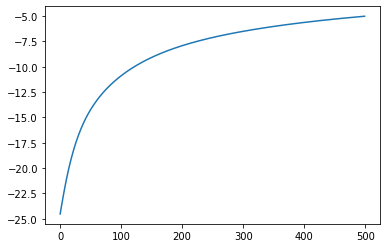

In [45]:
plt.plot(llv[1:])

In [ ]:
## torch.optim version (no loop)

X = torch.tensor(xx[:,:2])
S = torch.tensor(xx[:,2])

#parameters = [emu_c, eco_c, smu_c, sco_c]
#parameters = [emu_cc, eco_cc, smu_cc, sco_cc]
parameters = [emu_c, eco_c, smu_c, sco_c, emu_cc, eco_cc, smu_cc, sco_cc]
opt = optim.SGD(parameters, lr=0.01)
#opt = optim.Adam(parameters)

tot = 1e-4
llv = [0.0]

log_pi_d0 = torch.log(pi_d0)
log_pi_d1 = torch.log(1-pi_d0)
log_pi_c = torch.log(pi_c)
log_pi_cc = torch.log(pi_cc)

#iter = 0
#n_epochs = 500
#while iter < n_epochs:

log_post_top0 = torch.zeros(n_clusters, n_obs)
log_post_top1 = torch.zeros(n_clusters, n_clusters, n_obs)

for j in range(n_clusters):  
  el0 = D.MultivariateNormal(emu_c[j], eco_c[j]).log_prob(X.float())
  sl0 = D.Normal(smu_c[j], sco_c[j]).log_prob(S.float())
  log_post_top0[j] = log_pi_d0 + log_pi_c[j] + el0 + sl0

  for k in range(n_clusters):
    el1 = D.MultivariateNormal(emu_cc[j,k]/2, eco_cc[j,k]/2).log_prob(X.float())
    sl1 = D.Normal(smu_cc[j,k], sco_cc[j,k]).log_prob(S.float())
            
    if torch.isnan(pi_cc[j,k]): #lower triangular nan
      log_post_top1[j,k] = float("-Inf")
    else:
      log_post_top1[j,k] = log_pi_d1 + log_pi_cc[j,k] + el1 + sl1

log_post_bot0 = torch.logsumexp(log_post_top0, 0) #n
  
log_post_top1 = log_post_top1.reshape(n_clusters * n_clusters, n_obs) #reshape
log_post_bot1 = torch.logsumexp(log_post_top1, 0) #n

log_post_tot = torch.logsumexp(torch.vstack((log_post_top0, log_post_top1)),0)
loss = -torch.mean(log_post_tot)

#print(emu_c)
opt.zero_grad()
loss.backward()
opt.step()
#print(emu_cc)

with torch.no_grad():
  parameters[0].clamp_(tot)
  ##parameters[1].clamp_(tot)
  parameters[2].clamp_(tot)
  parameters[3].clamp_(tot)
  parameters[4].clamp_(tot)
  ##parameters[5].clamp_(tot)
  parameters[6].clamp_(tot)
  parameters[7].clamp_(tot)

  log_post_d0 = log_post_bot0 - log_post_tot
  log_post_d1 = log_post_bot1 - log_post_tot

  log_post_z = (log_post_top0 - log_post_bot0).T #nxc (rjk)
  log_post_g = (log_post_top1 - log_post_bot1).T #nxc (rijk)

  log_post_dz = log_post_d0[:,None] + log_post_z
  log_post_dg = log_post_d1[:,None] + log_post_g

  #r_ij = torch.exp(log_post_dz)
  #n_c = torch.sum(r_ij, dim=0)
  #pi_c = n_c / n_obs  # c values
  log_n_c = torch.logsumexp(log_post_dz, 0)
  log_pi_c = log_n_c - torch.log(torch.tensor(n_obs))

  #r_ijk = torch.exp(log_post_dg).reshape(n_obs, n_clusters, n_clusters)
  #n_cc = torch.sum(r_ijk, dim=0) # (cxc)
  #pi_cc = n_cc / n_obs  # cxc matrix

  log_n_cc = torch.logsumexp(log_post_dg, 0).reshape(n_clusters, n_clusters)
  log_pi_cc = log_n_cc - torch.log(torch.tensor(n_obs))  # cxc matrix

  #pi_d0 = torch.sum(torch.exp(log_post_d0)) / n_obs # one value
  log_pi_d0 = torch.logsumexp(log_post_d0, 0) - torch.log(torch.tensor(n_obs))

print('Iteration', iter + 1, 'Likelihood: ', -loss, torch.exp(log_pi_d0))

#if abs(llv[-1] + loss) < tot:
#  break
      
llv.append(-loss)
iter += 1

aic, bic = _ics(-loss, n_obs, n_features, n_clusters)

#print(epoch, pi_d0, loss)